# Tet River and Microplastic: Water Discharge

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LightSource, ListedColormap
import pandas as pd
import seaborn as sns
import rasterio as rio
from rasterio.plot import show
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime
from pyproj import Proj, Transformer

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

from pathlib import Path

## Tet Catchment

The Têt River is a typical coastal Mediterranean river with a drainage catchment area lower than 5000 km$^{2}$. The coastal plain of the Têt watershed is characterized by agricultural activities, as well as the location of the largest city of the district (Perpignan, about 150,000 inhabitants). Two major dams exist in the Têt River basin and they lie upstream the densely populated coastal plains. The most downstream dam is at Vinça.

In [2]:
vinca = (662580, 6173257)

path_to_tif = Path('/work/armitagj/code/caesarPy/dem-preprocessing/tet/')
raster = path_to_tif/'tet-tsm-station-dem_clipped.tif'
dem = rio.open(raster)
Z = dem.read(1).astype(float).T

nx, ny = np.shape(Z)
ll = (dem.transform[2], dem.transform[5] + ny * dem.transform[4])
dx = dem.transform[0]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X, Y = np.meshgrid(x, y, indexing='ij')

print(f'{np.shape(X)} {np.shape(Y)} {np.shape(Z)}')

(3453, 1471) (3453, 1471) (3453, 1471)


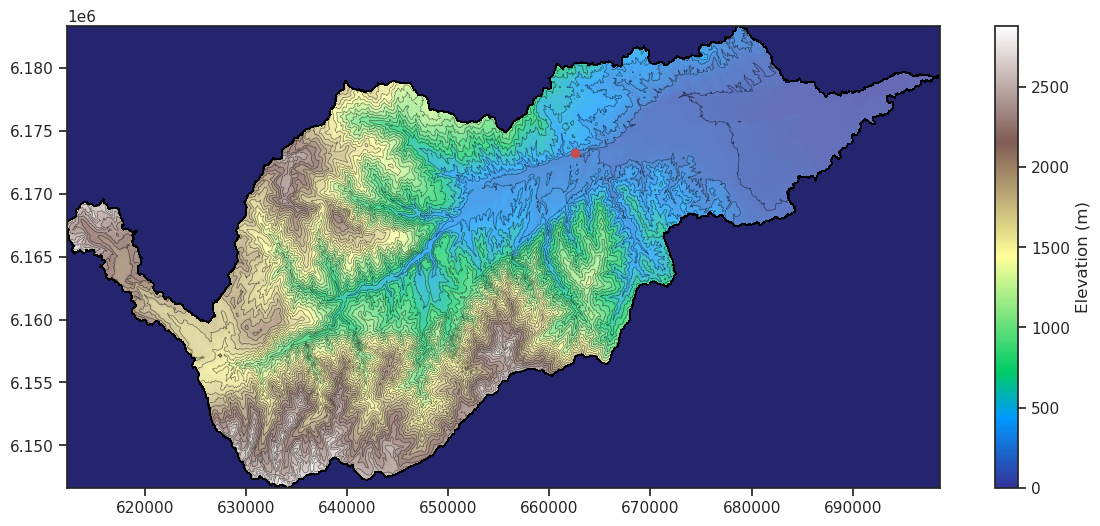

In [3]:
ls = LightSource(azdeg=0, altdeg=125)
bumps = ls.hillshade(Z) #**0.25

mi, ma = np.floor(np.nanmin(Z)), np.ceil(np.nanmax(Z))
levels = np.arange(mi, ma, 100)

sns.set(rc={'figure.figsize':(6 * nx / ny, 6)})
sns.set_style("ticks")
plt.figure()
plt.pcolormesh(X, Y, Z, cmap='terrain', vmin=0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.pcolormesh(X, Y, Z, cmap='gray', alpha=0.27)
plt.contour(X, Y, Z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.plot(vinca[0], vinca[1], 'or')
plt.savefig('plots/tet-catchment.png', dpi=300)
plt.show()

In [4]:
raster = path_to_tif/'CATCHMENT_TET_DOWN_DAM_VINCA.tif'
dem = rio.open(raster)
Zv = dem.read(1).astype(float).T

nxv, nyv = np.shape(Zv)
ll = (dem.transform[2], dem.transform[5] + nyv * dem.transform[4])
dx = dem.transform[0]

xv = np.linspace(ll[0], ll[0] + dx * (nxv -1), nxv)
yv = np.linspace(ll[1] + dx * (nyv -1), ll[1], nyv)
Xv, Yv = np.meshgrid(xv, yv, indexing='ij')

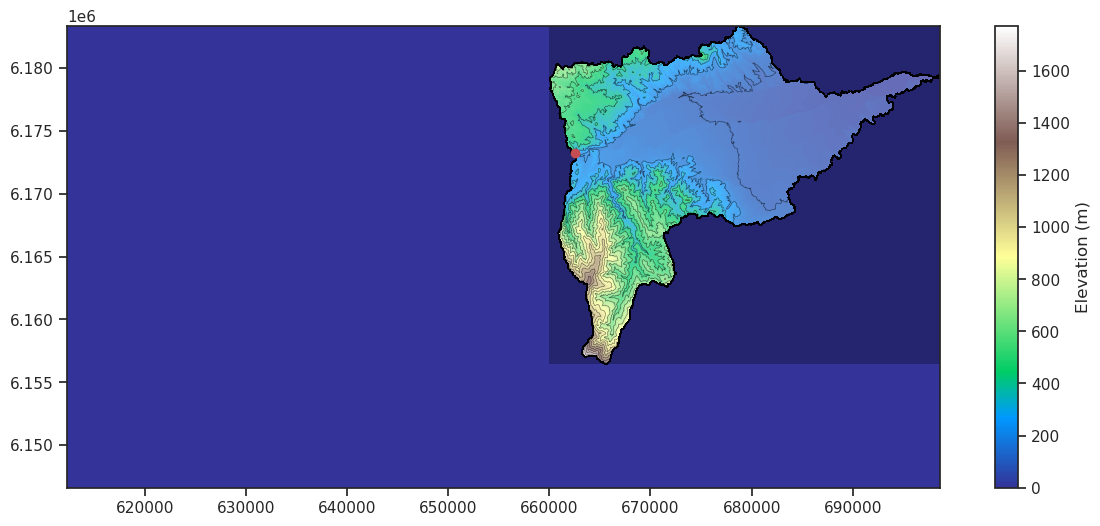

In [5]:
sns.set(rc={'figure.figsize':(6 * nx / ny, 6)})
sns.set_style("ticks")
plt.figure()
plt.pcolormesh(X, Y, np.zeros(np.shape(X)), cmap='terrain', vmin=0)
plt.pcolormesh(Xv, Yv, Zv, cmap='terrain', vmin=0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.pcolormesh(Xv, Yv, Zv, cmap='gray', alpha=0.27)
plt.contour(Xv, Yv, Zv, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.plot(vinca[0], vinca[1], 'or')
plt.savefig('plots/tet-vinca-catchment.png', dpi=300)
plt.show()

The dam at Vinça is situated at the top of the alluvial plain of the Têt catchment. The drainage area below this dam is significantly smaller than that above. We will make the assumption that this dam captures a significant quantity of the upstream discharge, and take the DEM of the region below the Vinça.

## Rainfall

We take the simplifying assumption that each weather station is representative of the region around it, regardles of topography. We therefore interpolate the rainfall data using a simple nearest neighbour algorithm from `scipy`.

In [6]:
ascfile = path_to_tif/'spatial_rain_050m.asc'
nxr, nyr, geotransform, Zr = cp.demio.asc2numpy(str(ascfile))

ll = (geotransform[0], geotransform[3] + nyr * geotransform[5])
dx = geotransform[1]

xr = np.linspace(ll[0], ll[0] + dx * (nxr -1), nxr)
yr = np.linspace(ll[1] + dx * (nyr -1), ll[1], nyr)
Xr, Yr = np.meshgrid(xr, yr, indexing='xy')

In [7]:
ascfile = path_to_tif/'dem_050m_preproc.asc'
nxv, nyv, geotransform, Zv = cp.demio.asc2numpy(str(ascfile))

In [8]:
ls = LightSource(azdeg=0, altdeg=125)
bumps = ls.hillshade(Z) #**0.25

mi, ma = np.floor(np.nanmin(Z)), np.ceil(np.nanmax(Z))
levels = np.arange(mi, ma, 100)

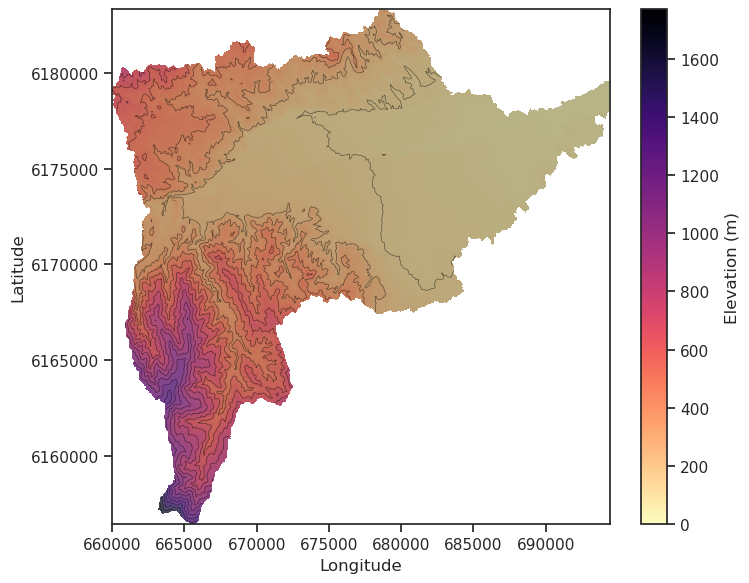

In [9]:
sns.set(rc={'figure.figsize':(6 * nxv / nyv, 6)})
sns.set_style("ticks")
fig, ax = plt.subplots()
pc = ax.pcolormesh(Xr, Yr, Zv, cmap='magma_r', vmin=0)
cbar = plt.colorbar(pc)
cbar.ax.set_ylabel('Elevation (m)')
ax.pcolormesh(Xr, Yr, Zv, cmap='gray', alpha=0.27)
ax.contour(Xr, Yr, Zv, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
ax.ticklabel_format(style='plain')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('plots/tet-vinca-catchment.png', dpi=300)
plt.show()

In [10]:
names=['66002001',
       '66013001',
       '66026001',
       '66029003', 
       '66037001',
       '66136001',
       '66183001',
       '66230001',
       '66233001']

cnames = ['tab:blue',
          'tab:orange',
          'tab:green',
          'tab:red',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'tab:olive',
          'tab:cyan']

cmrain = ListedColormap(cnames)

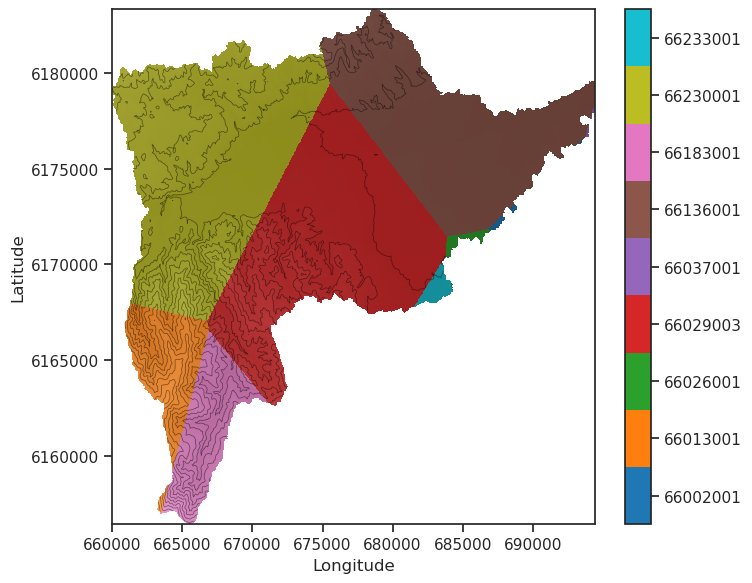

In [11]:
fig, ax = plt.subplots(figsize=[6 * nxv / nyv, 6])
pc = ax.pcolormesh(Xr, Yr, Zr, cmap=cmrain, vmin=0.001)
cb = plt.colorbar(pc)
cb.set_ticks(np.arange(len(names)) + .5, labels=names)
cb.ax.invert_xaxis()
ax.pcolormesh(Xr, Yr, Zv, cmap='gray', alpha=0.27)
ax.contour(Xr, Yr, Zv, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
ax.ticklabel_format(style='plain')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('plots/tet-rainfall-zones.png', dpi=300, bbox_inches = "tight")
plt.show()

In [12]:
rainfile = path_to_tif/'spatial_rain.txt'
df = pd.read_csv(rainfile, delimiter=' ', names=names)
s = datetime.datetime.strptime('10/1/2015 12:00:00', '%m/%d/%Y %H:%M:%S')
date_rng = pd.date_range(start=s, periods=len(df), freq='D')
df['date'] = date_rng[:len(df)]
df.set_index('date', drop=False, inplace=True)

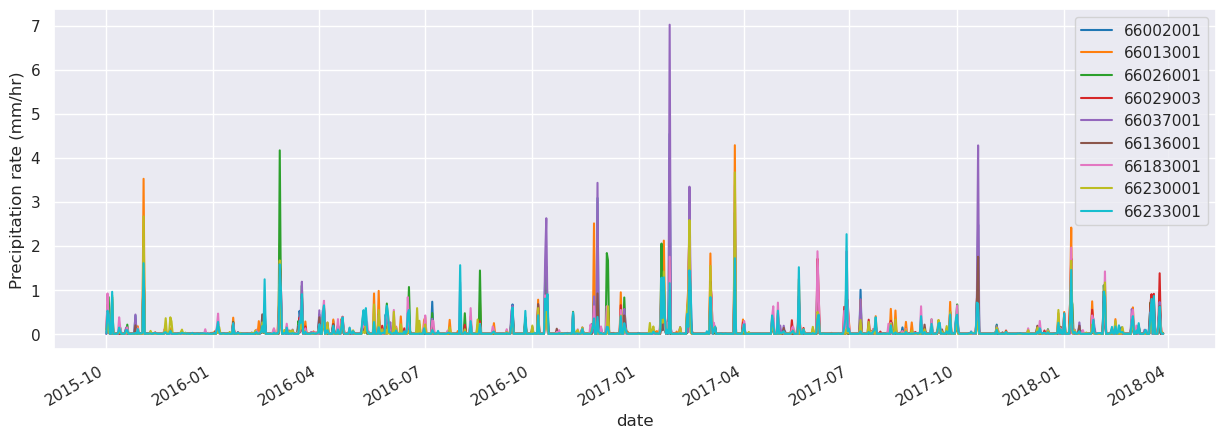

In [13]:
sns.set(rc={'figure.figsize':(15, 5)})
plt.figure()
for i, name in enumerate(names):
    df[name].plot(marker='', alpha=1, color=cnames[i])
plt.ylabel('Precipitation rate (mm/hr)')
plt.legend()
plt.savefig('plots/tet-vinca-rainfall.png', dpi=300)
plt.show()

## Model Results

The rainfall from each station acts on the area defined above. I run the model for two cycles, to allow for a wind-up of the model. I will analyze the second period where I vary two parameters, the percentage of the rainfall that is assumed to hit be converted to run-off via the loss due to evapotranspiration and loss to deeper groundwater reservoirs. I will the discharge for 80, 60 and 40\,% of the rainfall. I will also vary the water storage parameter $m$ from TOPMODEL.

### Example model run

Below I plot the output of a model run with 40\,% of the precipitation and a $m = 0.01$.

In [14]:
path_to_file = Path('/work/armitagj/runs/caesar-explore/tet/spatial-rain-initial-below-vinca-loop-mfilled/')

In [15]:
file = path_to_file/'results.r40_m0.010/sedoutput.dat'
seds_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
# seds_['Qw(actual)'] = seds_['Qw(actual)'] * 60 * 60  # Qw is in m3/sec -> m3/hr
density = 1330
rock = 2660
seds_['SSC'] = seds_['Suspended'] * density / (seds_['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds
seds_['Bedload'] = (seds_['Sand'] + seds_['Gravel']) * rock / seds_['Qw(actual)']

In [16]:
rain = np.load('../../dem-preprocessing/tet/mean_rainfall_below_vinca.npy')
seds_['rain'] = np.concatenate((rain, rain[1:]), axis=0)
s = datetime.datetime.strptime('10/1/2015 12:00:00', '%m/%d/%Y %H:%M:%S') - datetime.timedelta(days=len(rain))
date_rng = pd.date_range(start=s, periods=len(seds_), freq='D')
seds_['date'] = date_rng[:len(seds_)]
seds_all = seds_.set_index('date', drop=False)

<Figure size 1500x1500 with 0 Axes>

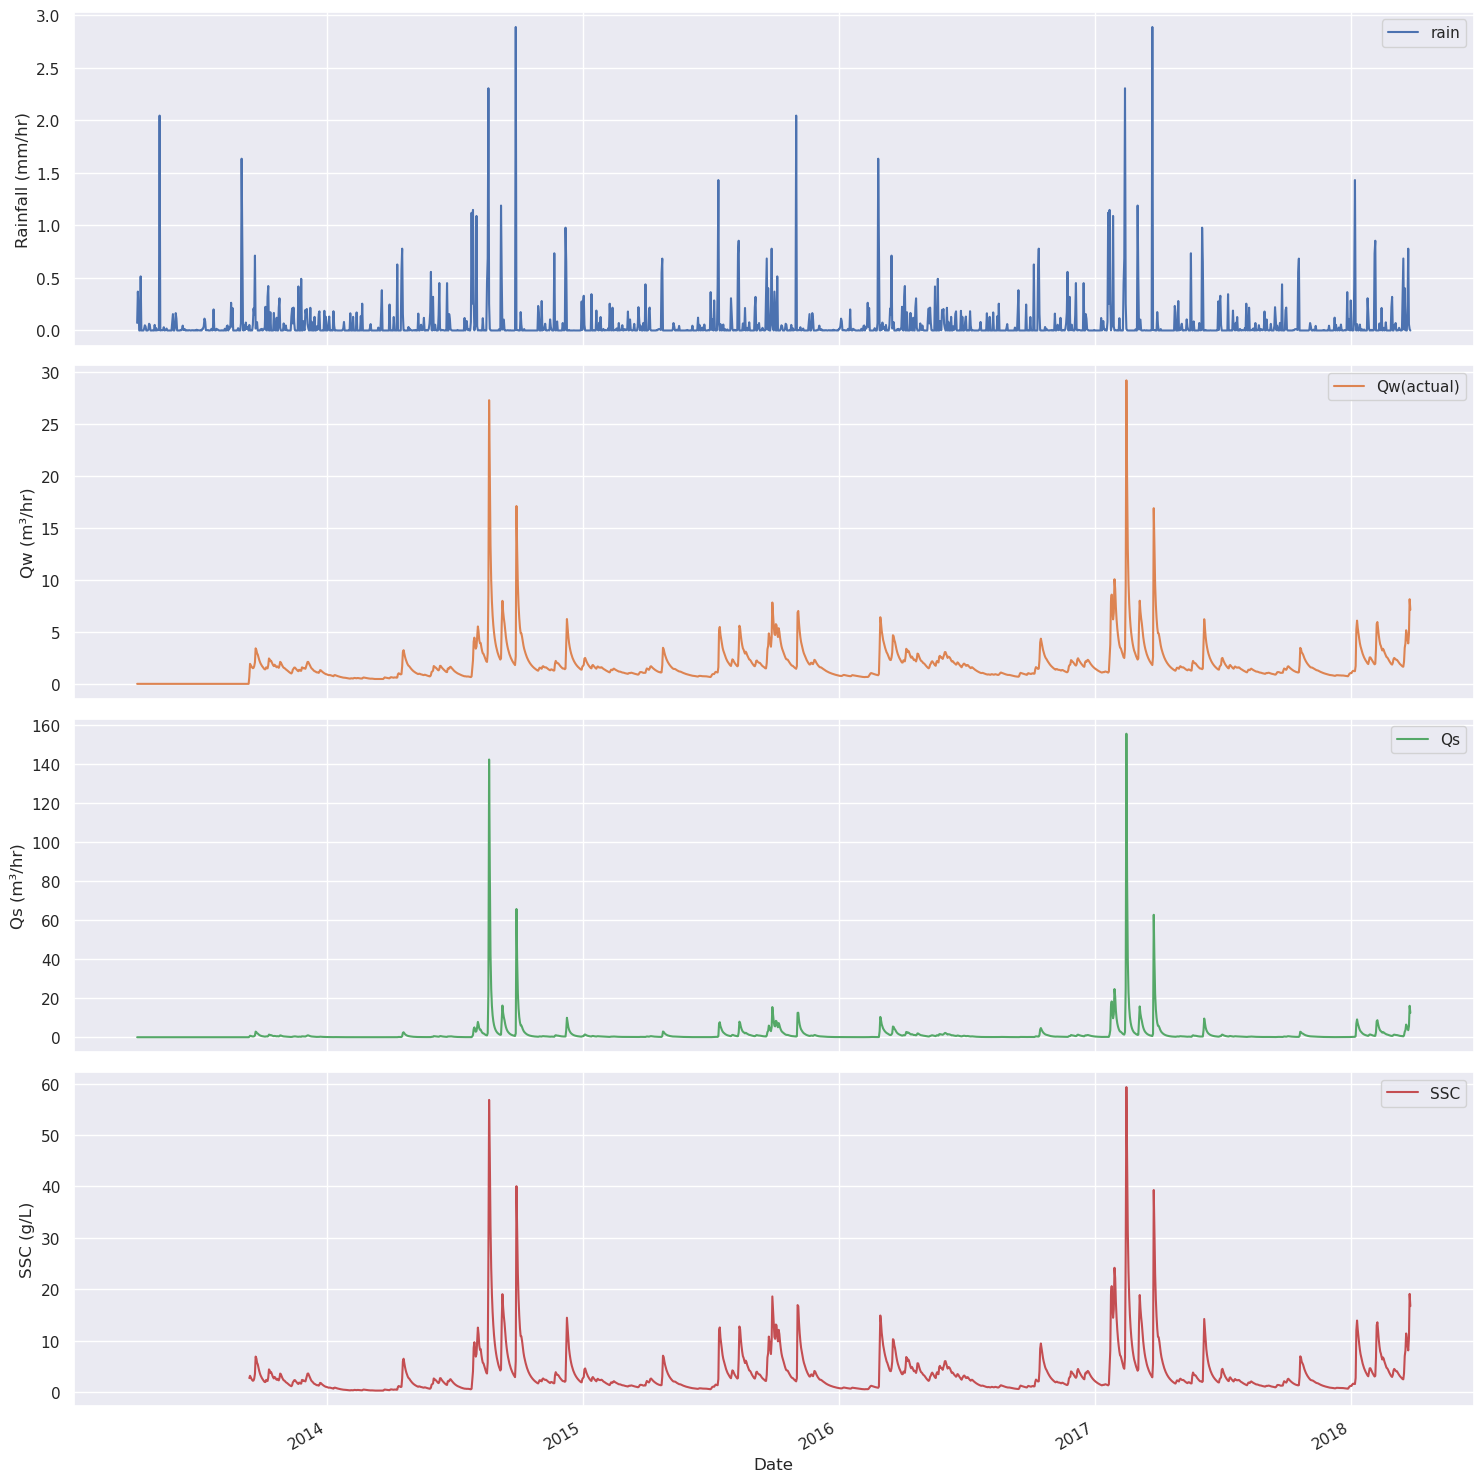

In [17]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['rain', 'Qw(actual)', 'Qs', 'SSC']
cols_label = ['Rainfall (mm/hr)', 'Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Date')
plt.tight_layout()
#plt.savefig('plots/timeseries_{}.png'.format(name), dpi=300)
plt.show()

In [18]:
lasttime = 2613600 # output time stamp to plot
lastdays = lasttime/60/24
cut = 100  # point on x axis to plot cross section of DEM (resolution dependent)
print(f'Last Output at {lastdays} days')

Last Output at 1815.0 days


In [19]:
ascfile = path_to_file/f'results.r40_m0.010/Elevations{lasttime}.asc'
ncols, nrows, geotransform, z = cp.demio.asc2numpy(str(ascfile))

z = np.flip(np.flip(z, 1), 0)

ll = (geotransform[0], geotransform[3] + nrows * geotransform[5])
dx = geotransform[1]

_x = np.linspace(ll[0], ll[0] + dx * (ncols -1), ncols)
_y = np.linspace(ll[1] + dx * (nrows -1), ll[1], nrows)
x, y = np.meshgrid(_x, _y, indexing='xy')

grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = ascfile = path_to_file/f'results.r40_m0.010/Elevations{0}.asc'
ncols, nrows, geotransform, zstart = cp.demio.asc2numpy(str(ascfile))

zstart = np.flip(np.flip(zstart, 1), 0)

z0 = pv.StructuredGrid(x, y, zstart)
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))

In [20]:
ls = LightSource(azdeg=0, altdeg=125)
bumps = ls.hillshade(z) #**0.25

In [21]:
mi, ma = np.floor(np.nanmin(z)), np.ceil(np.nanmax(z))
levels = np.arange(mi, ma, 100)

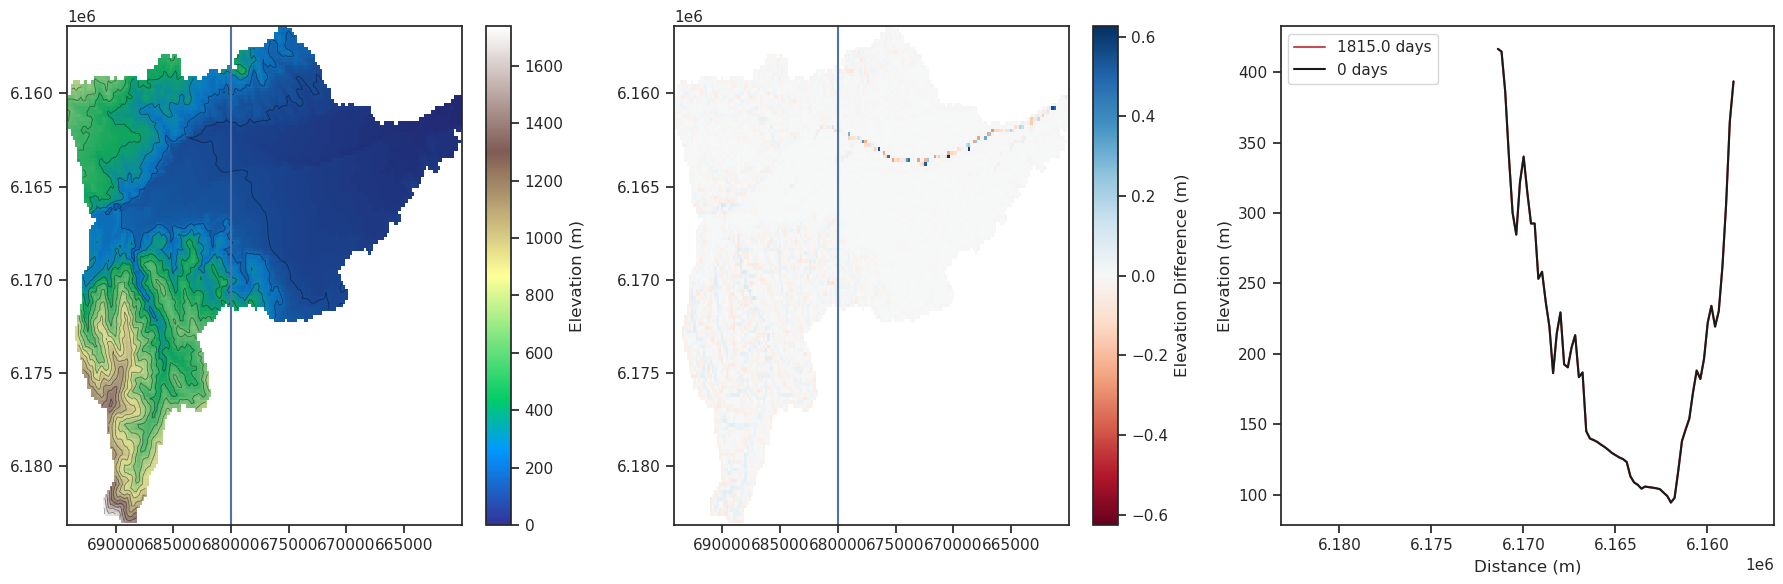

In [22]:
sns.set(rc={'figure.figsize':(18, 6)})
sns.set_style("ticks")
plt.figure()
plt.subplot(1,3,1)
plt.pcolormesh(x, y, z, cmap='terrain', vmin=0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.pcolormesh(x, y, z, cmap='gray', alpha=0.27)
plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.plot(x[:,cut], y[:,cut])

plt.subplot(1,3,2)
clim = np.nanmax(np.abs(z-zstart))
plt.pcolormesh(x, y, z-zstart, cmap='RdBu', vmin=-clim, vmax=clim)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation Difference (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.plot(x[:,cut], y[:,cut])

plt.subplot(1,3,3)
plt.plot(y[:,cut], z[:,cut], 'r')
plt.plot(y[:,cut], zstart[:,cut], 'k')
plt.xlim(y.max(), y.min())
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.legend([f'{lastdays} days','0 days'])
plt.tight_layout()
#plt.savefig('plots/CL_profile_{}.png'.format(name), dpi=300)
plt.show()

In [23]:
ascfile = ascfile = path_to_file/f'results.r40_m0.010/WaterDepths{lasttime}.asc'
ncols, nrows, geotransform, water = cp.demio.asc2numpy(str(ascfile))

# the matrix gets fliped when I read it (180° rotation)
water = np.flip(np.flip(water, 1), 0)
#water[np.isnan(z)] = np.nan

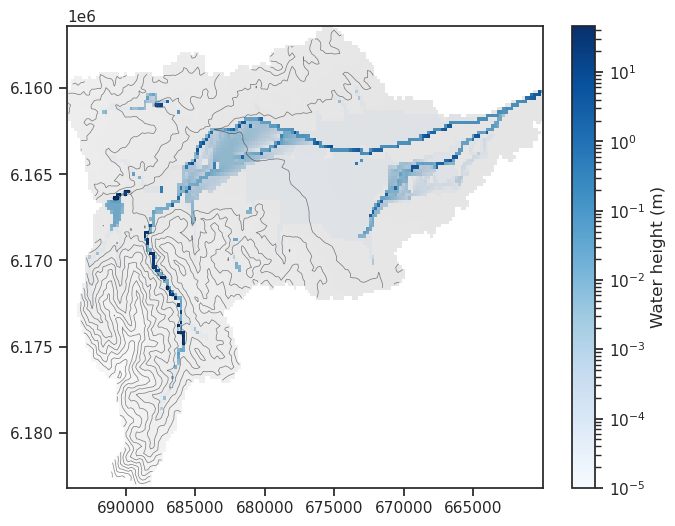

In [24]:
sns.set(rc={'figure.figsize':([6 * nxv / nyv, 6])})
sns.set_style("ticks")
plt.figure()
plt.pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-5, vmax=water.max()), cmap='Blues')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Water height (m)')
plt.pcolormesh(x, y, z, cmap='gray', alpha=0.1)
plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.savefig('plots/tet-water.png', dpi=300)
plt.show()

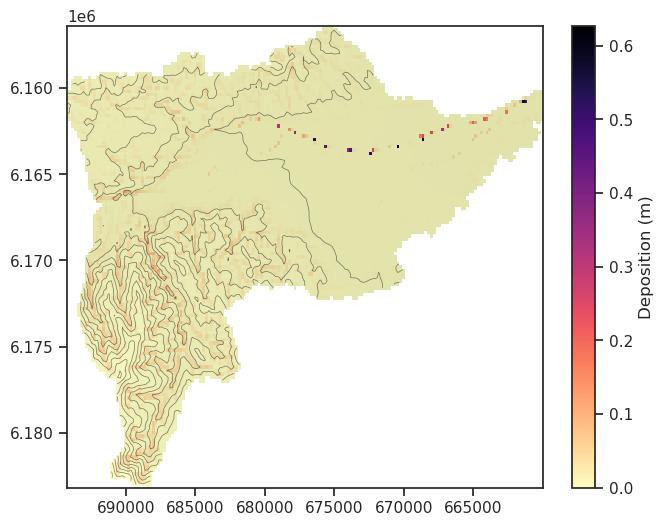

In [25]:
acc = z-zstart
acc[acc<0] = 0

sns.set(rc={'figure.figsize':([6 * nxv / nyv, 6])})
sns.set_style("ticks")
plt.figure()
clim = np.nanmax(np.abs(z-zstart))
plt.pcolormesh(x, y, acc, cmap='magma_r', vmin=0, vmax=clim)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Deposition (m)')
plt.pcolormesh(x, y, z, cmap='gray', alpha=0.1)
plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())
plt.savefig('plots/tet-DEM-diff.png', dpi=300)
plt.show()

## Obseration data

Three data sources:

- MP measurements with associated MES from ([Constant et al., 2020](#)) via Sébastien Rohais
- Water flux from the site hydrométrique - Y047 4030 : La Têt à Perpignan (Pont-Joffre) (https://www.hydro.eaufrance.fr)
- MES and water flux data given to me by Mel and published in ([Constant et al., 2020](#))

In [26]:
file = './data/mp_fluxes_tet.csv'
df = pd.read_csv(file)
df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [27]:
file = './data/water-flux-Pont-Joffre-hydroportail.csv'
pont_joffre = pd.read_csv(file)
pont_joffre['datetime'] = pd.to_datetime(pont_joffre['Date (TU)'], format='%Y-%m-%dT%H:%M:%S.000Z')

In [28]:
file = './data/MES.csv'
mes = pd.read_csv(file, delimiter=';', decimal=',')
mes['datetime'] = pd.to_datetime(mes['Date'], format='%d/%m/%y')
file = './data/FMES_wl.csv'
fmes = pd.read_csv(file, decimal=',')
fmes['datetime'] = pd.to_datetime(fmes['Date'], format='%d.%m.%Y')

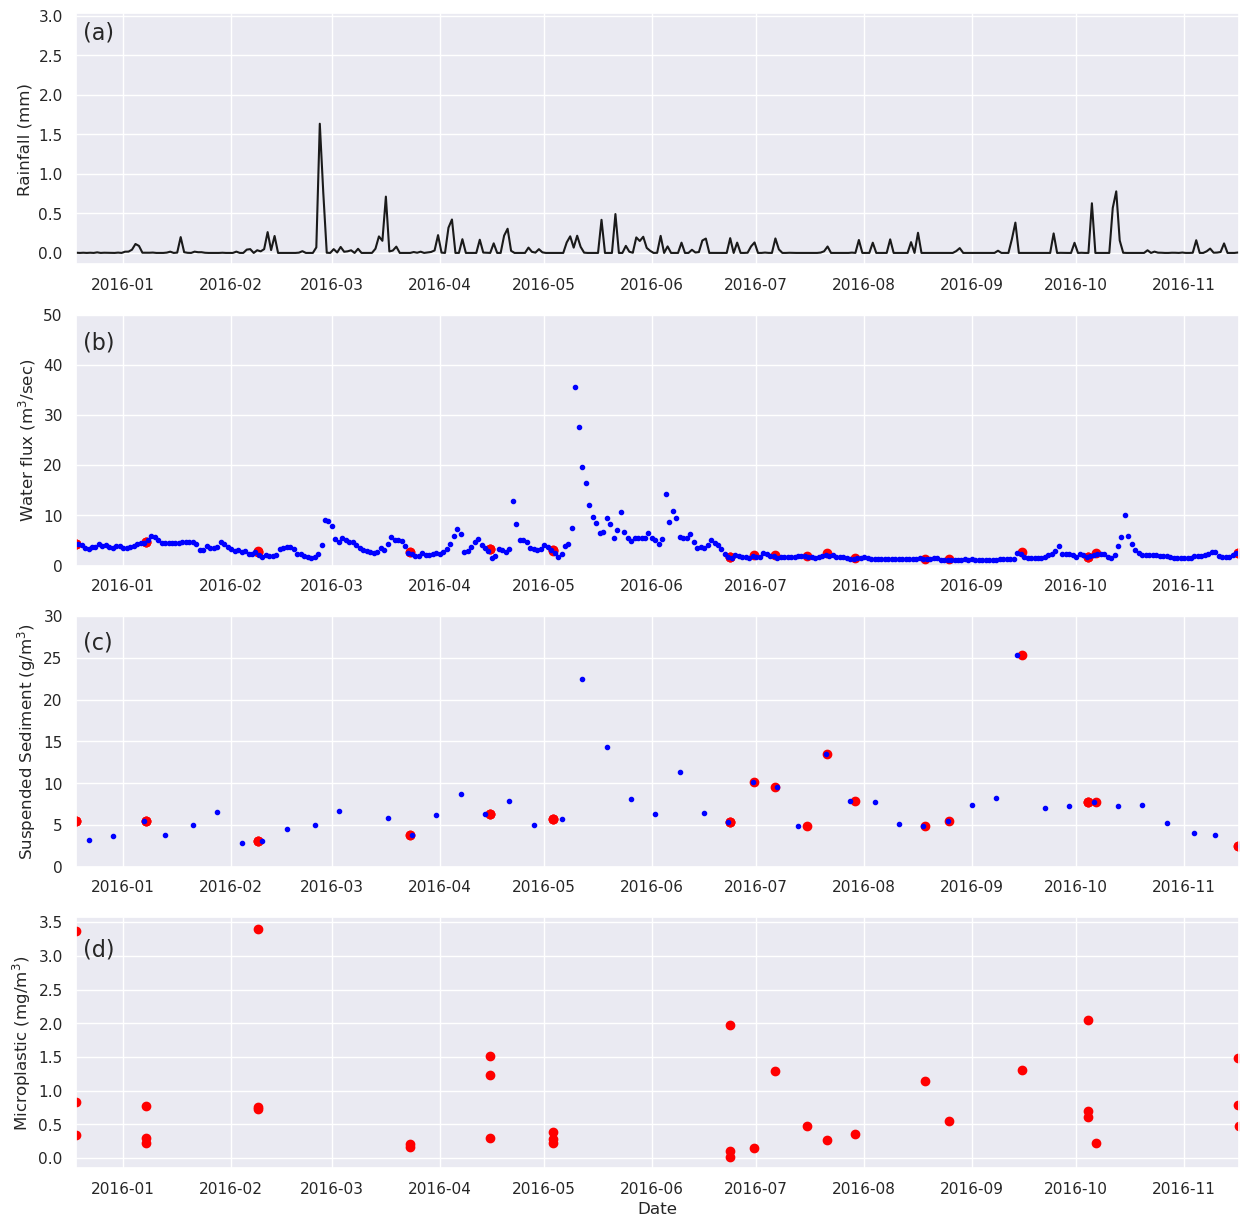

In [29]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()   
plt.subplot(4,1,1)
plt.plot(seds_all['date'], seds_all['rain'], 'k')
plt.text(df['datetime'].min(), 2.7, ' (a)', fontsize=16)
plt.ylabel('Rainfall (mm)')
plt.xlim(df['datetime'].min(), df['datetime'].max())
plt.subplot(4,1,2)
plt.plot(df['datetime'], df['Q (m3/s)'], 'o', color='red')
plt.plot(pont_joffre['datetime'], pont_joffre['Valeur (en m³/s)'], '.', color='blue')
plt.text(df['datetime'].min(), 43, ' (b)', fontsize=16)
plt.ylabel('Water flux (m$^{3}$/sec)')
plt.xlim(df['datetime'].min(), df['datetime'].max())
plt.ylim(0, 50)
plt.subplot(4,1,3)
plt.plot(df['datetime'], df['MES (g/m3)'], 'o', color='red')
plt.plot(mes['datetime'], mes['MES'], '.', color='blue')
plt.text(df['datetime'].min(), 26, ' (c)', fontsize=16)
plt.ylabel('Suspended Sediment (g/m$^{3}$)')
plt.xlim(df['datetime'].min(), df['datetime'].max())
plt.ylim(0, 30)
plt.subplot(4,1,4)
plt.plot(df['datetime'], df['MP (mg/m3)'], 'o', color='red')
plt.text(df['datetime'].min(), 3, ' (d)', fontsize=16)
plt.ylabel('Microplastic (mg/m$^{3}$)')
plt.xlabel('Date')
plt.xlim(df['datetime'].min(), df['datetime'].max())
plt.tight_layout
plt.savefig('plots/tet-observations.png', dpi=300)
plt.show()

### Quality of fit

The reservoir at Vinça has a large impact on the water flux. The summer discharge peak of 36 m³/sec during 2016 does not correlate with any rainfall event. It does however correlate with a period where the water height behind the Vinça dam dropped significantly. Therefore, surface routing of rainfall cannot recreate the discharge peak observed. To estimate the quality of of the fit between the model and the observations we will therefore focus on two time periods: (1) from February 2016 until May 2016 and July 2016 until late November 2016.

In [30]:
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2)))

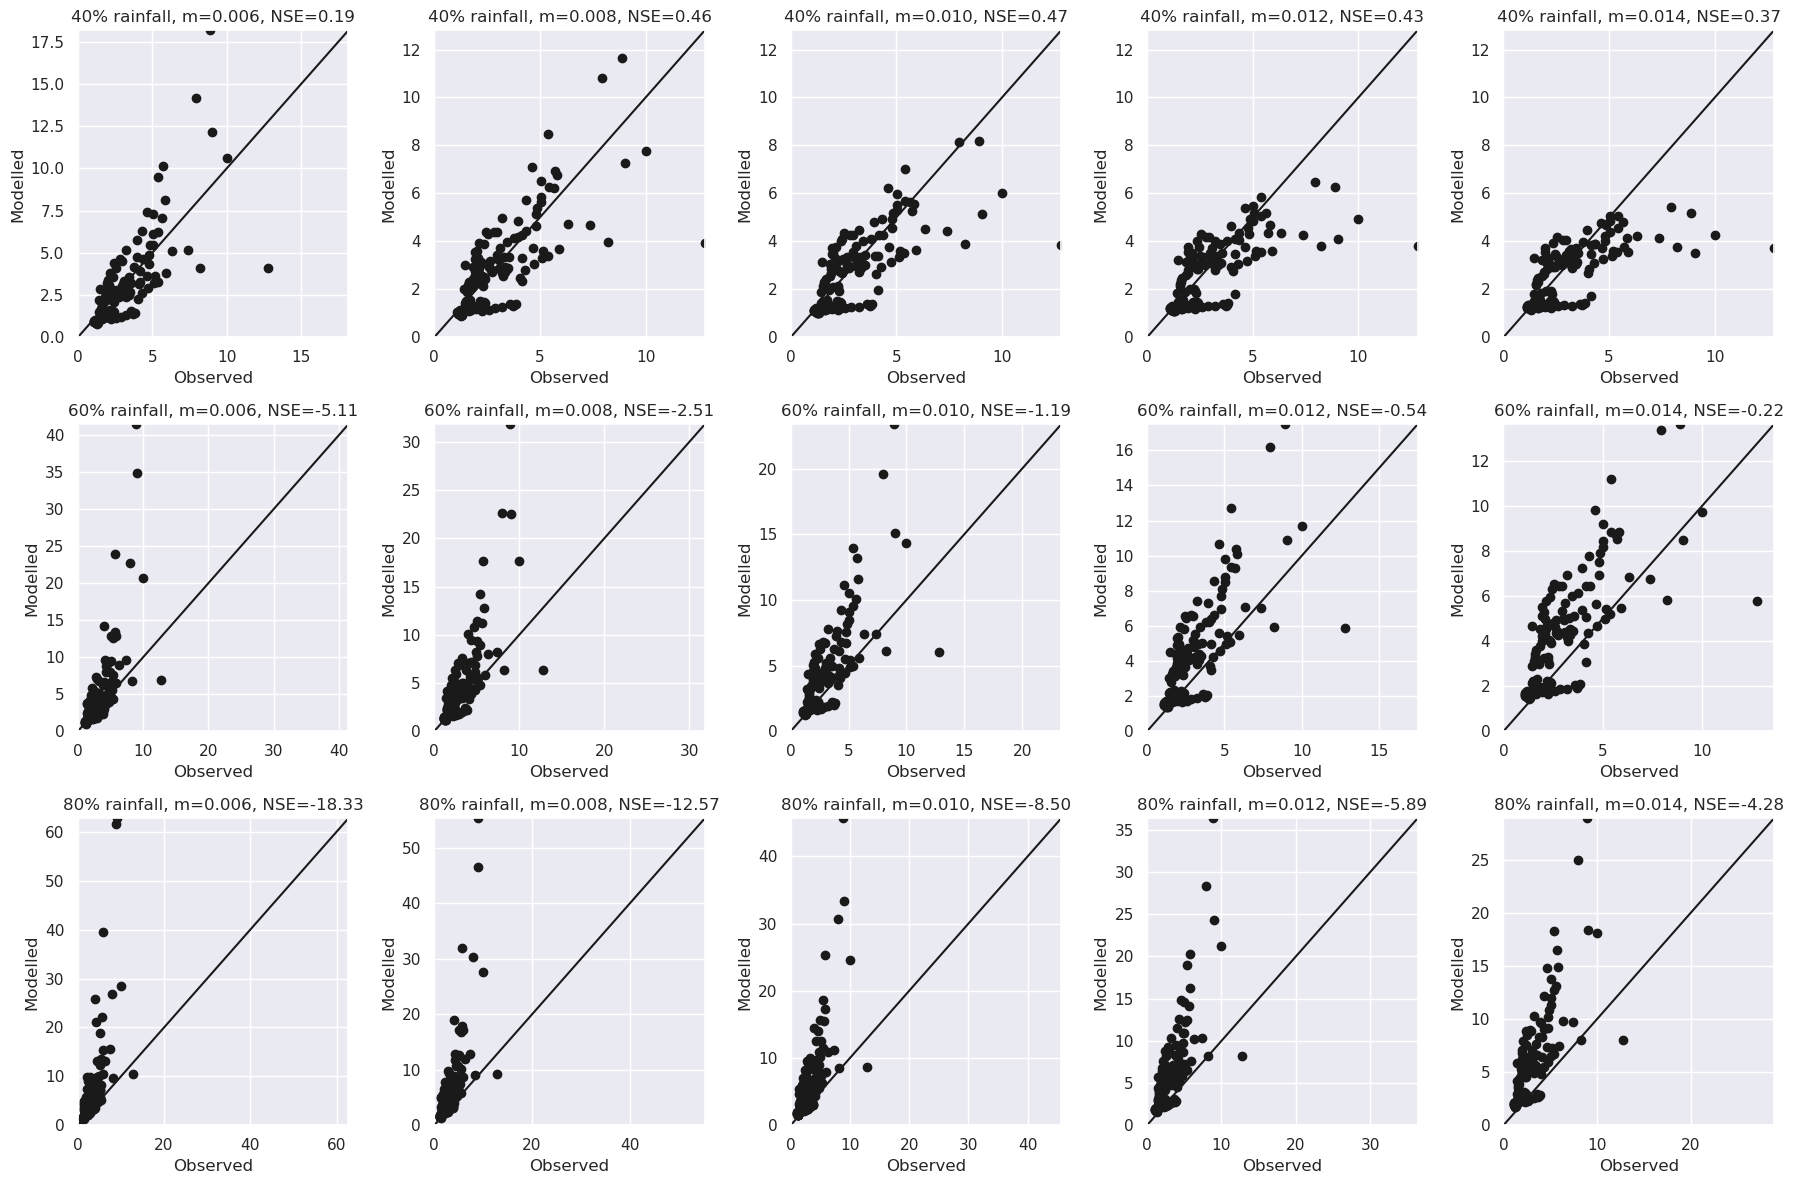

In [31]:
dfpont = pont_joffre.set_index('datetime', drop=True)
dfpont['Qobs'] = dfpont['Valeur (en m³/s)']
dfpont.drop(columns=['Date (TU)',
                     'Valeur (en m³/s)',
                     'Statut',
                     'Qualification', 
                     'Méthode',
                     'Continuité'], inplace=True)

rain_pcs = [40, 60, 80]
ms = [0.006, 0.008, 0.010, 0.012, 0.014]
fit_nse = np.zeros((len(rain_pcs), len(ms)))

sns.set(rc={'figure.figsize':(18, 12)})
plt.figure()
p = 1

for i, rain_pc in enumerate(rain_pcs):
    for j, m in enumerate(ms):
        file = path_to_file/f'results.r{rain_pc}_m{m:.3f}/sedoutput.dat'
        seds_ = pd.read_csv(file, sep=' ', index_col=False,
                            names=['Time Step',
                                   'Qw(actual)',
                                   'Qw(expected)',
                                   'Blank', 'Qs',
                                   'Suspended',
                                   'Sand',
                                   'Gravel'])
        seds_['SSC'] = seds_['Suspended'] * density / (seds_['Qw(actual)'] * 60 * 60 * 24) * 1000
        seds_['Bedload'] = (seds_['Sand'] + seds_['Gravel']) * rock / seds_['Qw(actual)']
        seds_['rain'] = np.concatenate((rain, rain[1:]), axis=0)
        s = datetime.datetime.strptime('10/1/2015 12:00:00', '%m/%d/%Y %H:%M:%S') - datetime.timedelta(days=len(rain))
        date_rng = pd.date_range(start=s, periods=len(seds_), freq='D')
        seds_['date'] = date_rng[:len(seds_)]
        seds_all = seds_.set_index('date', drop=False)

        dfmod = seds_all.set_index('date', drop=True)
        dfmod['Qmod'] = dfmod['Qw(expected)']
        dfmod.drop(columns=['Time Step',
                            'Qw(actual)',
                            'Qw(expected)',
                            'Blank',
                            'Qs',
                            'Suspended',
                            'Sand',
                            'Gravel', 
                            'SSC', 
                            'Bedload', 
                            'rain'], inplace=True)

        df_interp = pd.concat([dfpont, dfmod]).sort_index()
        df_interp['Qmod'] = df_interp['Qmod'].interpolate()
        df_interp.dropna(inplace=True)
        
        
        date_start = datetime.datetime.strptime('02/15/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
        date_end = datetime.datetime.strptime('05/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
        df_spring = df_interp.loc[date_start:date_end]
        
        date_start = datetime.datetime.strptime('9/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
        date_end = datetime.datetime.strptime('11/01/2016 12:00:00', '%m/%d/%Y %H:%M:%S')
        df_autumn = df_interp.loc[date_start:date_end]
        
        df_combi = pd.concat([df_spring, df_autumn])
        
        nash = nse(df_combi['Qmod'].values, df_combi['Qobs'].values)
        
        sns.set(rc={'figure.figsize':(5, 5)})
        plt.subplot(3, 5, p)
        p = p + 1
        maxi = np.max([df_combi['Qobs'].max(), df_combi['Qmod'].max()])
        plt.plot(df_combi['Qobs'], df_combi['Qmod'], 'ok')
        plt.plot([0, maxi], [0, maxi], '-k')
        plt.xlabel('Observed')
        plt.ylabel('Modelled')
        plt.xlim(0, maxi)
        plt.ylim(0, maxi)
        plt.title(f'{rain_pc}% rainfall, m={m:.03f}, NSE={nash:.02f}')
                
        fit_nse[i, j] = nash

plt.tight_layout()
plt.savefig('plots/tet-fit.png', dpi=300)
plt.show()